In [1]:
using CairoMakie
using NCDatasets
using Oceananigans
using TopographicHorizontalConvection: HorizontalConvectionSimulation

In [2]:
using Interpolations
using NaNStatistics

In [3]:
ds = NCDataset(string("/pub/hfdrake/code/HorizontalConvection/output/turbulent_h0.6_section_snapshots.nc"))
x = ds["xC"][4+1:end-4]; Nx = length(x)
Ny = 1
z = ds["zC"][4+1:end-4]; Nz = length(z);

In [4]:
Δx = reshape(diff(ds["xF"])[4+1:end-4], Nx,1,1);
Δy = 1.; # periodic in y so just left positions
Δz = reshape(diff(ds["zF"])[4+1:end-4], 1,1,Nz);
ΔA = Δx.*Δy;
ΔV = ΔA.*Δz;

time = ds["time"][:];

In [5]:
#snapshot of buoyancy at time=25

b = ds["b"][4+1:end-4, 1:1, 4+1:end-4, 190];
size(b)

(2048, 1, 256)

In [6]:
function calc_zstar(b)
    
    wet = b.!=0.;
    b[.!wet] .= NaN;
    
    z_3d = repeat(reshape(z, 1,1,Nz), Nx, Ny, 1);
    b_flat = reshape(b, (Nx*Ny*Nz));
    wet_flat = reshape(wet, (Nx*Ny*Nz));
    z_flat = reshape(z_3d, (Nx*Ny*Nz));
    
    sort_idx = sortperm(b_flat);
    b_sorted, z_sorted = b_flat[sort_idx], z_flat[sort_idx];
    
    ΔV_flat = ΔV[sort_idx];
    
    A_wet = dropdims(sum(wet.*ΔA, dims=(1,2)), dims=(1,2));
    A_interpolation = linear_interpolation(z, A_wet, extrapolation_bc=Line());
    
    z_bot = ds["zF"][5] # ignore 4 halo points
    zstar_flat = zeros(size(b_sorted))
    zstar_flat[1] = z_bot
    for k in 2:length(b_sorted)
        A = A_interpolation(zstar_flat[k-1])
        if !isnan(b_sorted[k])
            zstar_flat[k] = zstar_flat[k-1] + ΔV_flat[k]/A
        else
            zstar_flat[k] = NaN
        end
    end
    
    unsort_idx = sortperm(sort_idx)
    zstar = reshape(zstar_flat[unsort_idx], size(b))

    return zstar
end

calc_zstar (generic function with 1 method)

In [20]:
zstar_25 = calc_zstar(b[:,:,:,]);
size(zstar_25)

(2048, 1, 256)

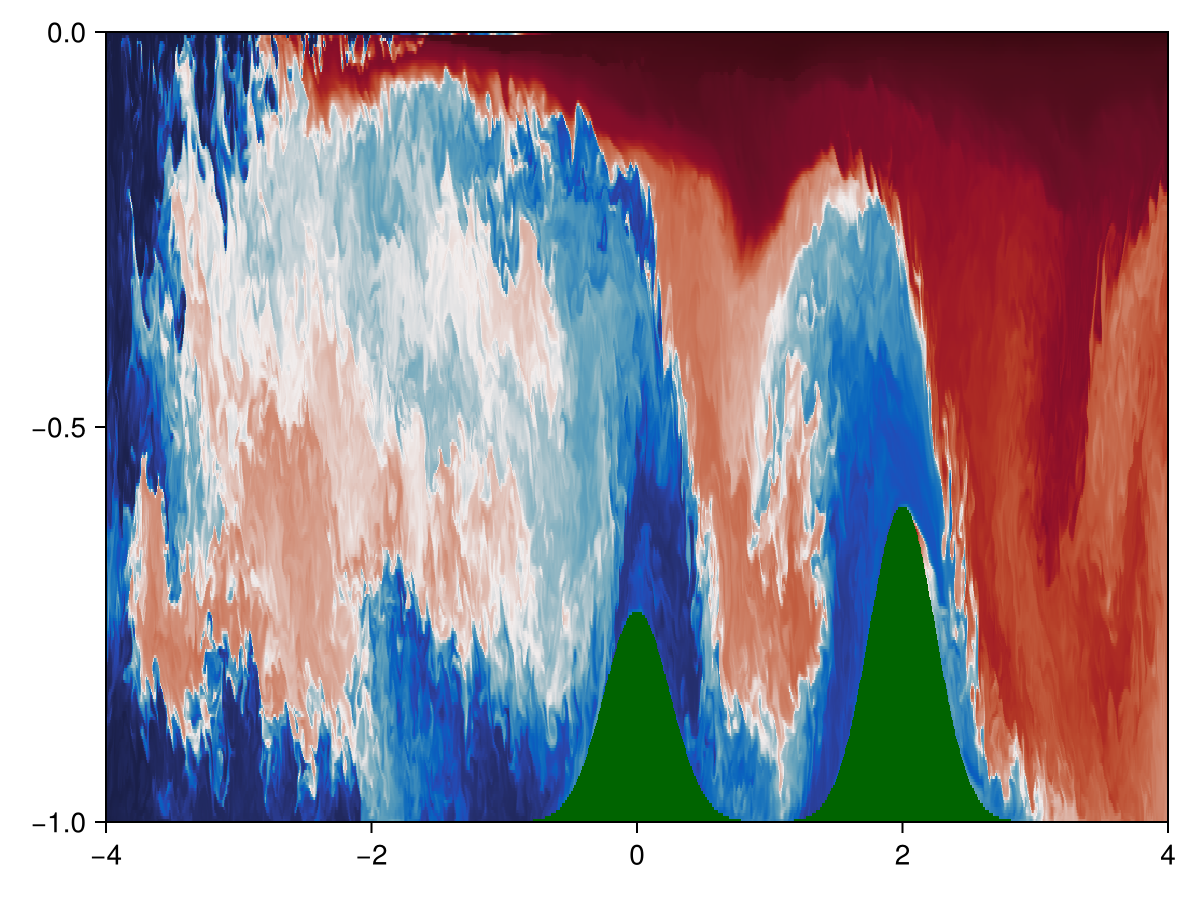

In [22]:

heatmap(x, z, zstar_25[:,1,:], colorrange=(-1, 0), colormap=:balance, nan_color=:darkgreen)